In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.figsize']=(15,15)
from jupyterthemes import jtplot
jtplot.style()
from utilidades import load_data
# from pandas_profiling import ProfileReport
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
afs=load_data()
pre_a=afs['afcal']
a=pre_a.rename(columns={'Unnamed: 0':'country','Unnamed: 1':'date'})

In [4]:
means_af=pd.DataFrame({'country':a['country'],
                      'date':a['date'],
                      'mean_af_in':a.reindex(columns=['af_in_pr','af_in_pr2','af_in_vl2'
                                          '	af_in_vl']).mean(axis=1),
                     'mean_af_ex':a.reindex(columns=['af_ex_pr','af_ex_pr2',
                                           'af_ex_vl','af_ex_vl2']).mean(axis=1),
                     'mean_af_in_pr':a.reindex(columns=['af_in_pr','af_in_pr2']).mean(axis=1),
                     'mean_af_in_vl':a.reindex(columns=['af_in_vl','af_in_vl2']).mean(axis=1),
                     'mean_af_ex_pr':a.reindex(columns=['af_ex_pr','af_ex_pr2']).mean(axis=1),
                     'mean_af_ex_vl':a.reindex(columns=['af_ex_vl','af_ex_vl2']).mean(axis=1)})

In [5]:
world = gpd.read_file('../world_shapefiles/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')
world = world[world.CNTRY_NAME !='Antarctica']

means_af_c = means_af.groupby('country').mean()

#discretize antif_means:
for column in means_af.columns[2:]:
    means_af_c[column+'_classes'] = pd.cut(means_af_c[column].values.flatten(),[-1,-.05,.05,1],labels=['fragile','robust','antifragile'])

In [7]:
world_af=pd.merge_ordered(world,means_af_c,left_on='CNTRY_NAME',right_on=means_af_c.index,how='outer')

In [8]:
world_af=world_af.set_geometry('geometry')

In [138]:
def maps_plots():
    missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///","label": "Missing values"}

    for antifrag in world_af.columns[4:]:

        fig,ax = plt.subplots(figsize=(20,10))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right",size="3%",pad=0.1)

        vmin=world_af.iloc[:,4:].min(numeric_only=True).min()
        vmax=world_af.iloc[:,4:].max(numeric_only=True).max()


        world_af.plot(column=antifrag,ax=ax,legend=True,cax=cax,missing_kwds=missing_kwds,vmin=vmin,vmax=vmax)
        ax.set_title(antifrag,fontsize=30)

In [139]:
def choropleth_classes(case):
    missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///","label": "Missing values"}

    path='mapasDE_classes_af'
    if not os.path.exists(os.path.join(path,case)):
        os.makedirs(os.path.join(path,case))

    for col in world_af.columns[-6:]:
        fig,ax = plt.subplots(figsize=(16,5))
        world_af.plot(column=col,missing_kwds=missing_kwds,ax=ax,legend=True)
        plt.title(col)

        plt.savefig(os.path.join(path,case,col+'.png'))        
        plt.close()

In [140]:
choropleth_classes('afcal')

### These are choropleth maps of antifragility and different antifragility normalizations. The following cases were considered because the components used for each mean are highly correlated, for example, af_in_pr is highly correlated with af_in_pr2. Furthermore, there is little difference between mean_af_in_pr and mean_af_in_vl. The same happens with mean_af_ex_pr and mean_af_ex_vl. Based on these observations, I would think that we should consider separately in and ex without accounting for price or volume factors.{-}

### mean_af_in is the mean of all the experiments with "in" (imports) in their name. {-}
### mean_af_ex the same as above but with "ex" (exports) {-}
### mean_af_in_pr is the mean of af_in_pr and af_in_pr2 {-}
### mean_af_in_vl is the mean of af_in_vl and af_in_vl2 {-}
### mean_af_ex_pr and mean_af_ex_vl are analogous to the above two cases. {-}

In [188]:
ii=np.flatnonzero(np.isfinite(np.c_[means_af['mean_af_in_pr'],
                                    means_af['mean_af_in_vl']]).all(1))
np.corrcoef(means_af['mean_af_in_pr'].loc[ii],means_af['mean_af_in_vl'].loc[ii])[0,1]

0.7561549157238859

In [187]:
ii=np.flatnonzero(np.isfinite(np.c_[means_af['mean_af_ex_pr'],
                                    means_af['mean_af_ex_vl']]).all(1))
np.corrcoef(means_af['mean_af_ex_pr'].loc[ii],means_af['mean_af_ex_vl'].loc[ii])[0,1]

0.7932185638888285

### Normal antifragility {-}

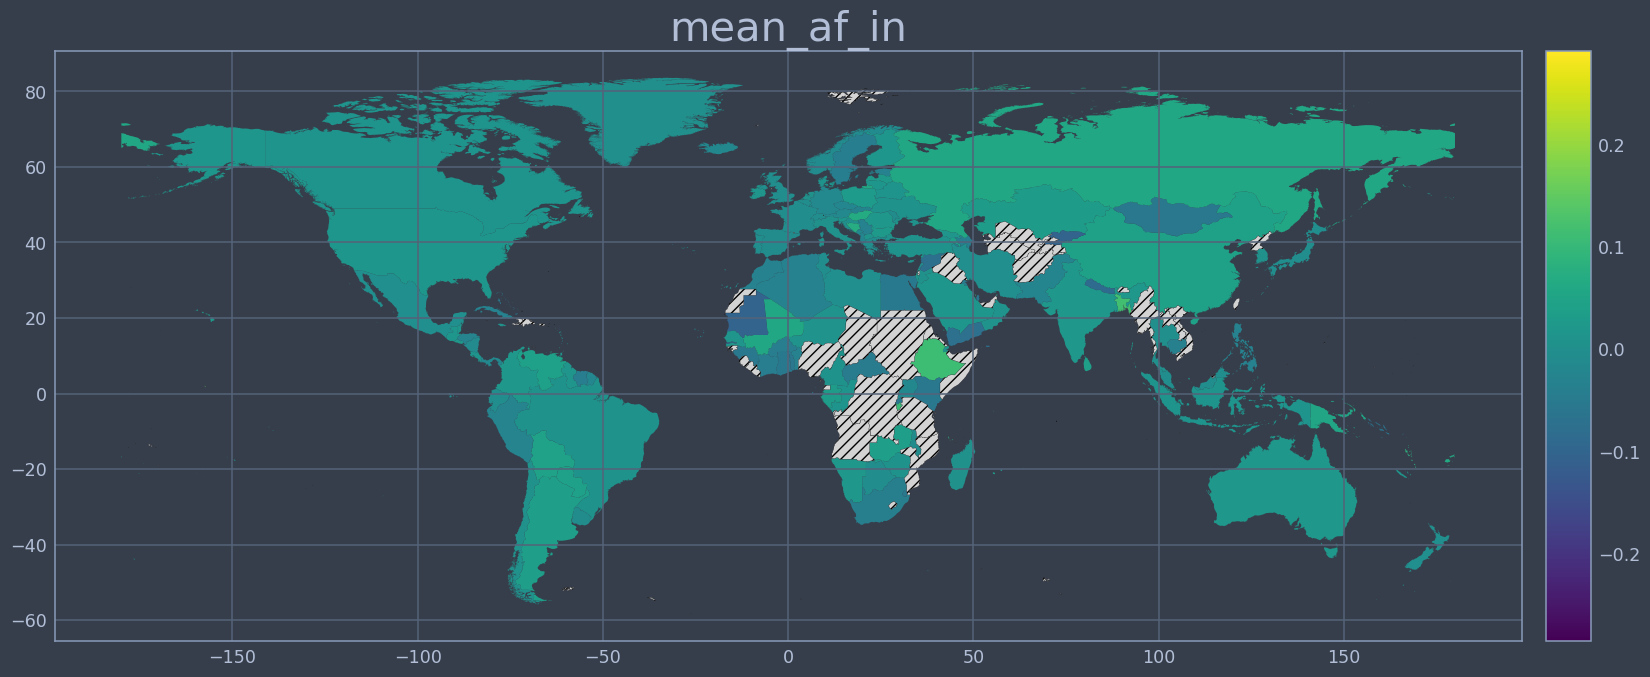

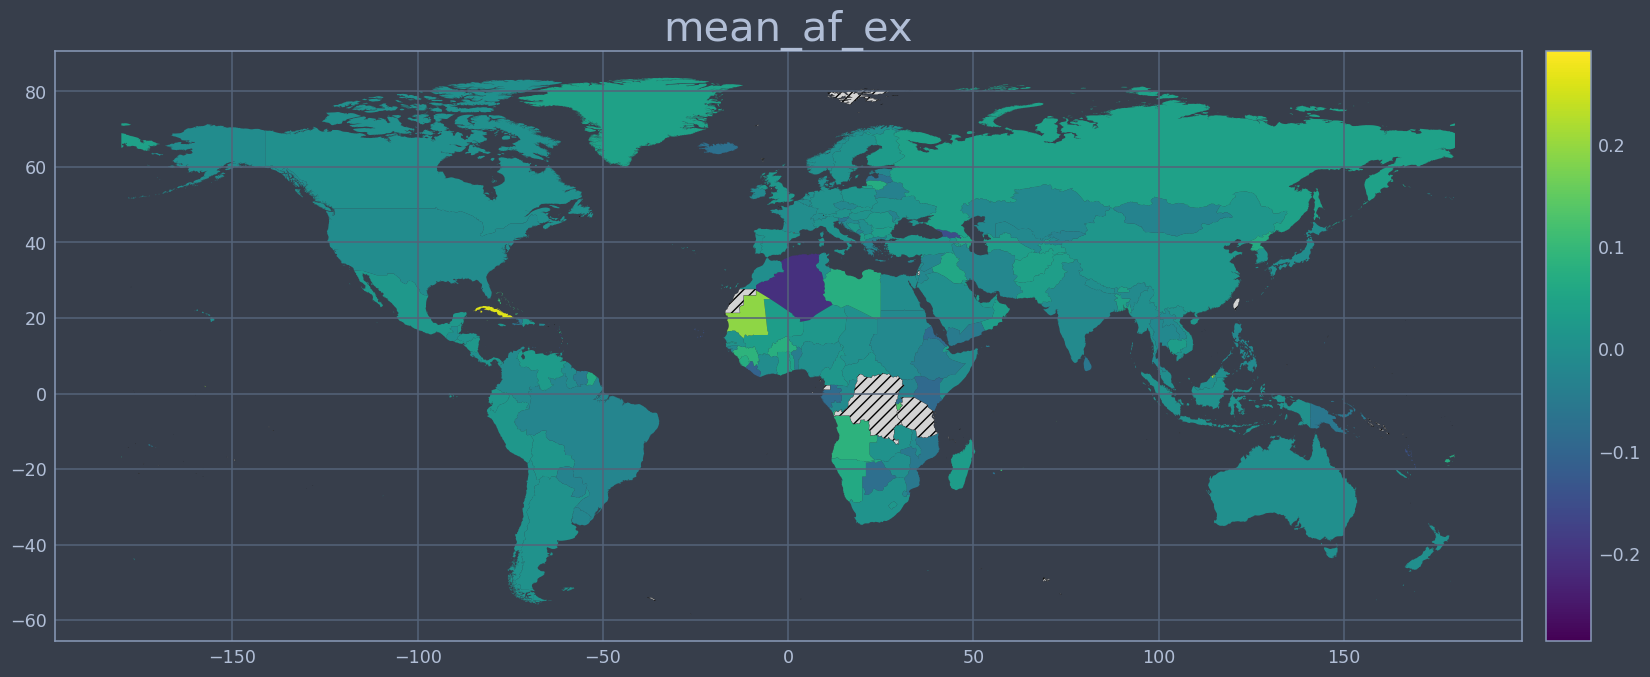

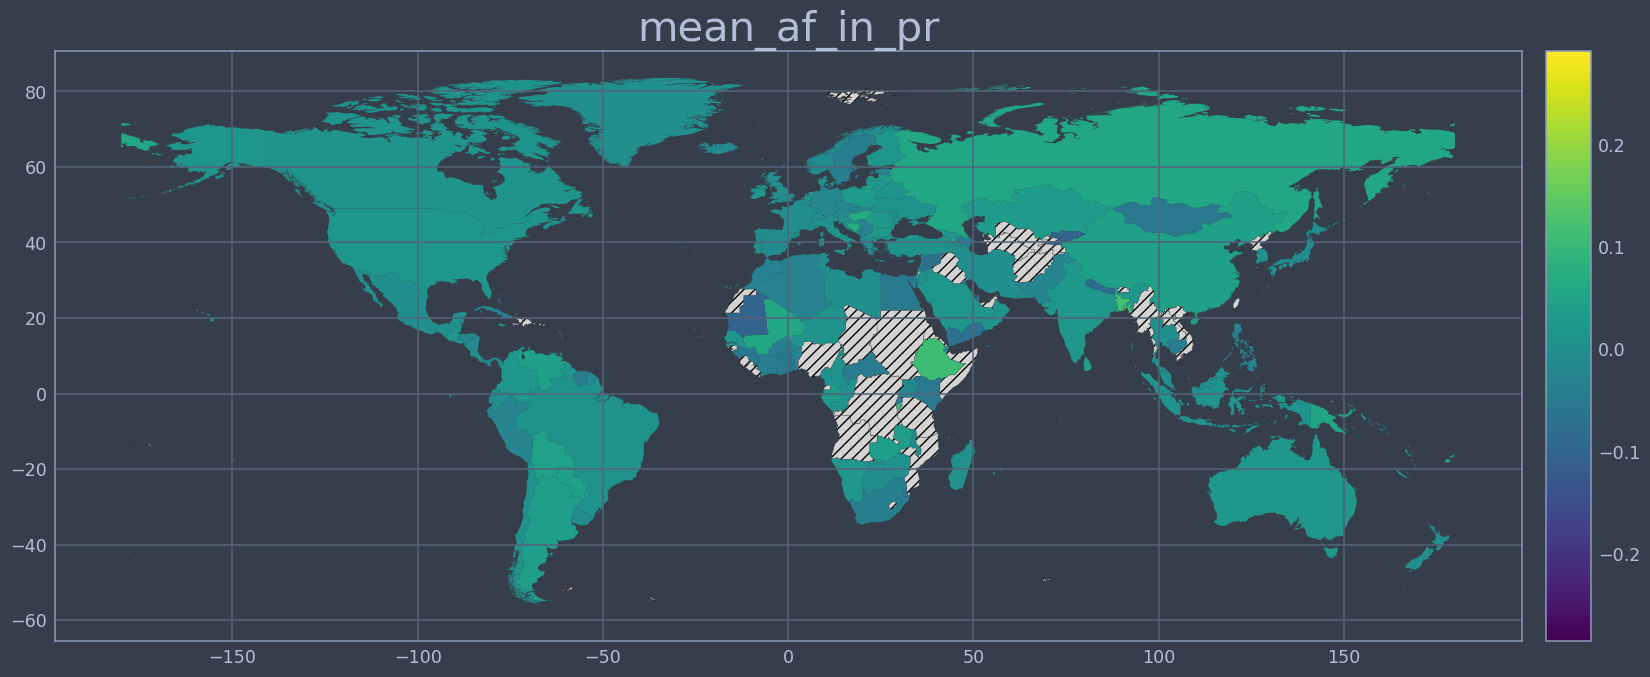

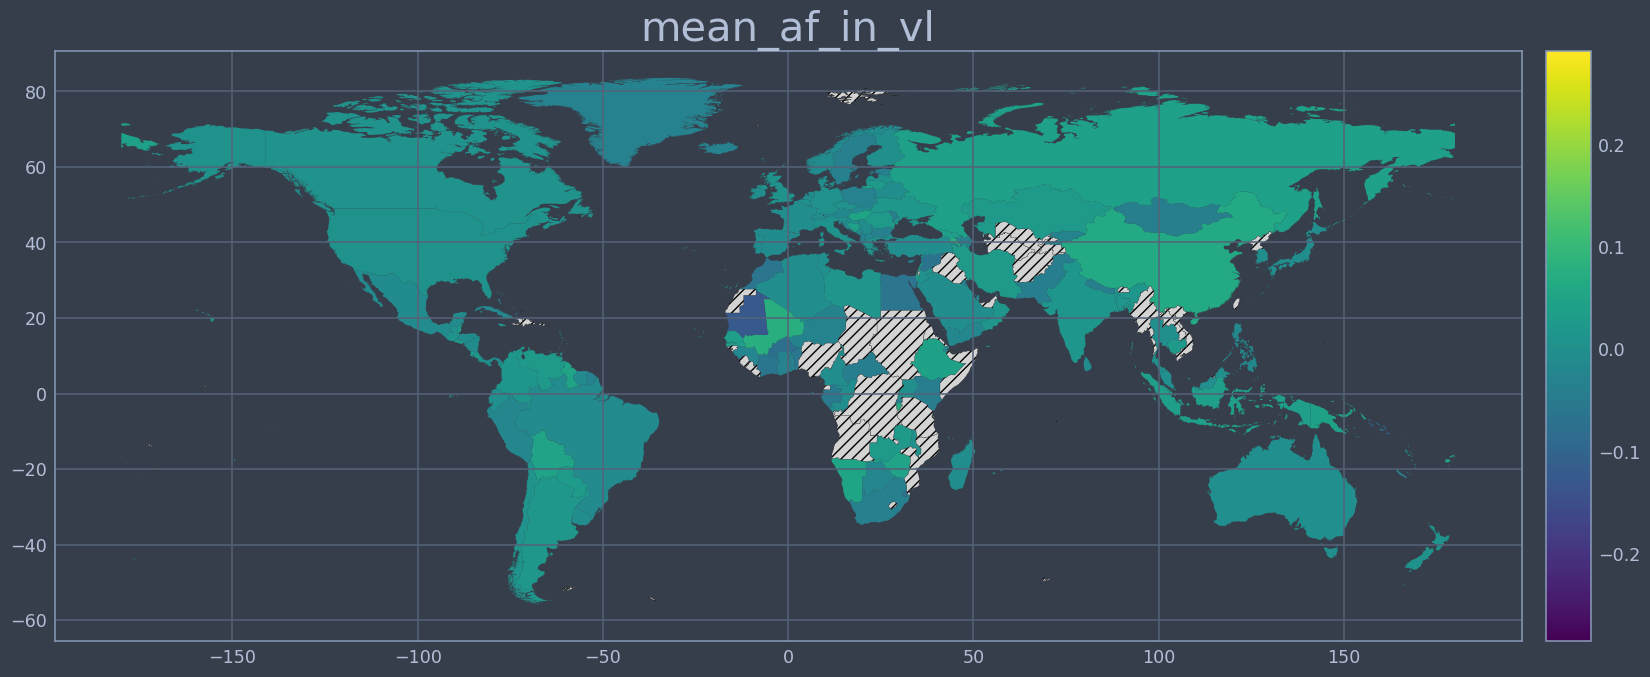

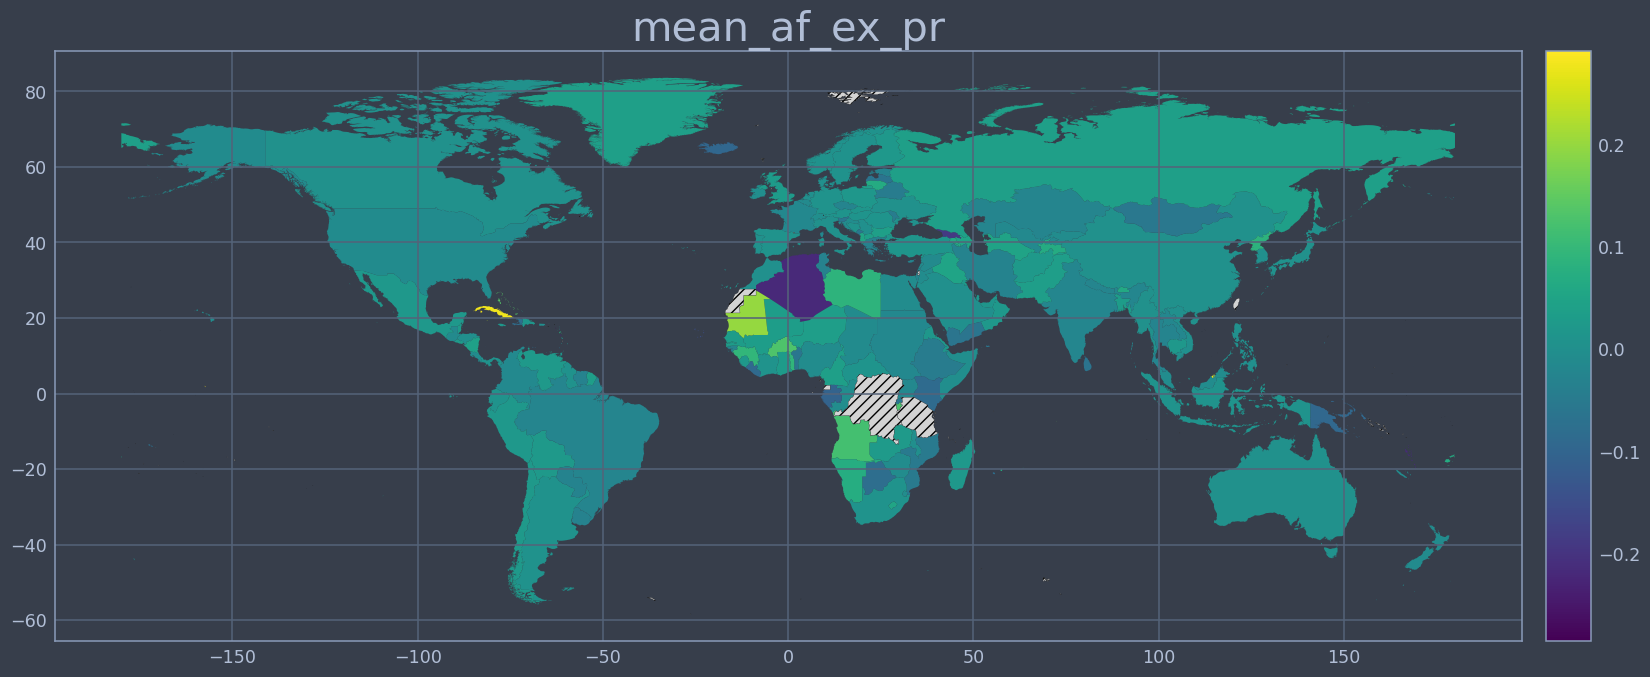

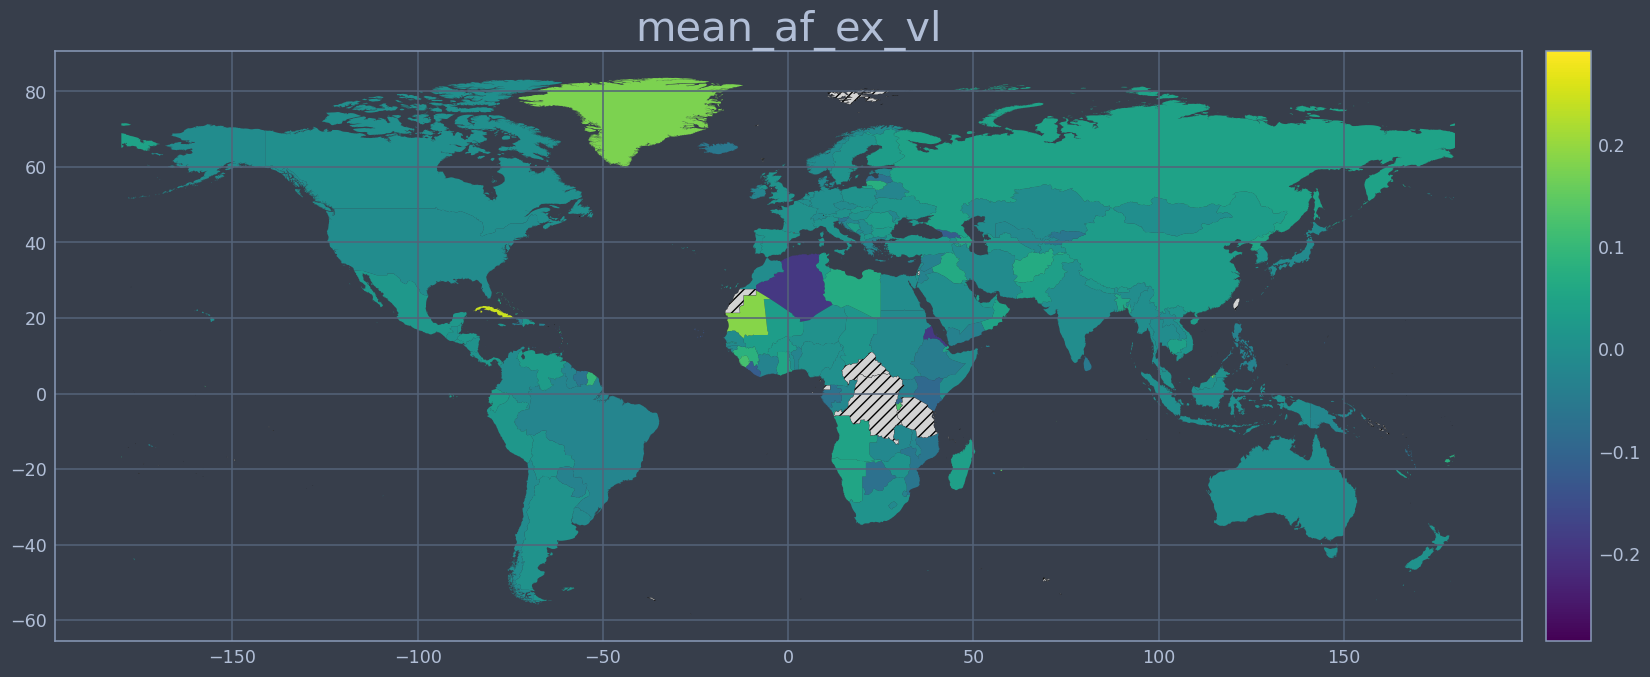

In [115]:
maps_plots()

### Caloric-normalized antifragility {-}

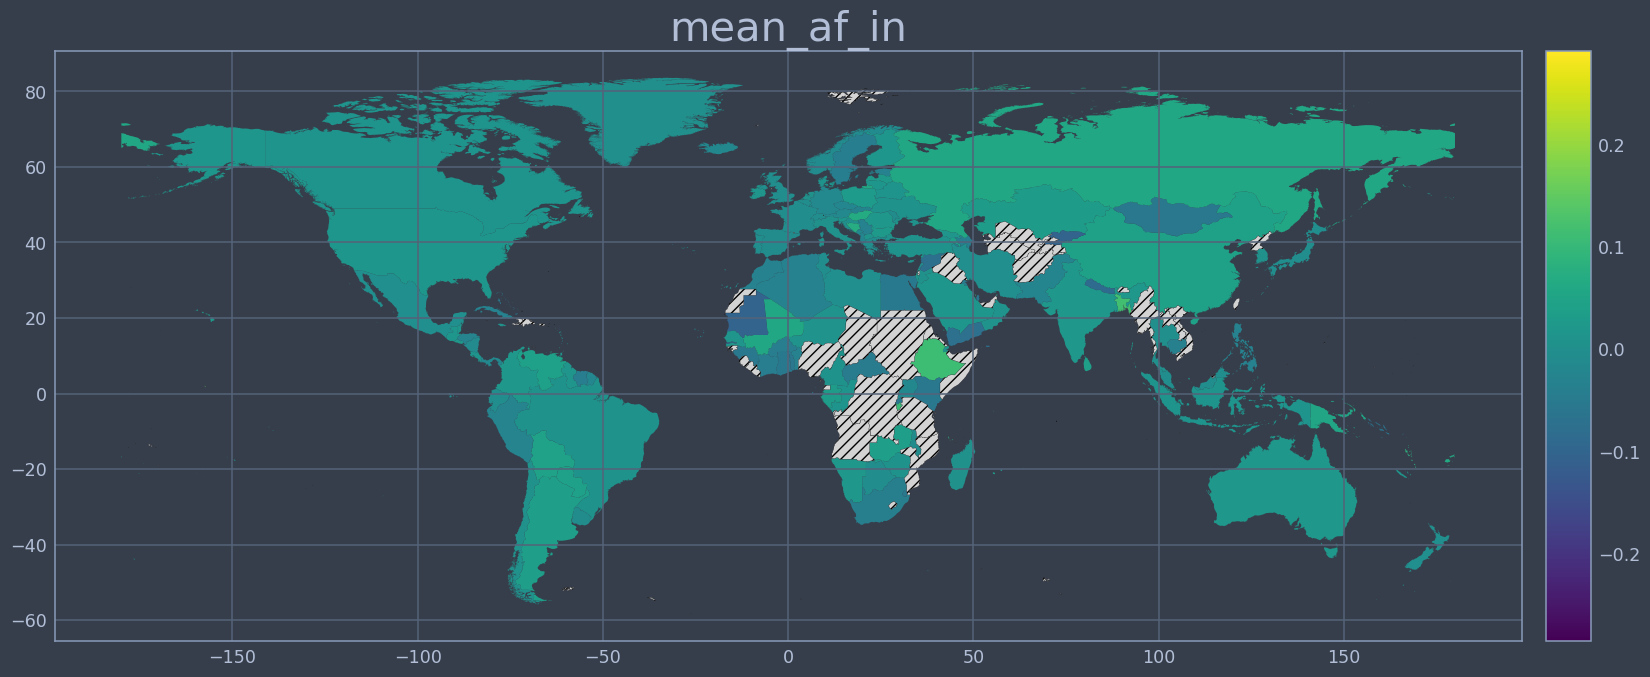

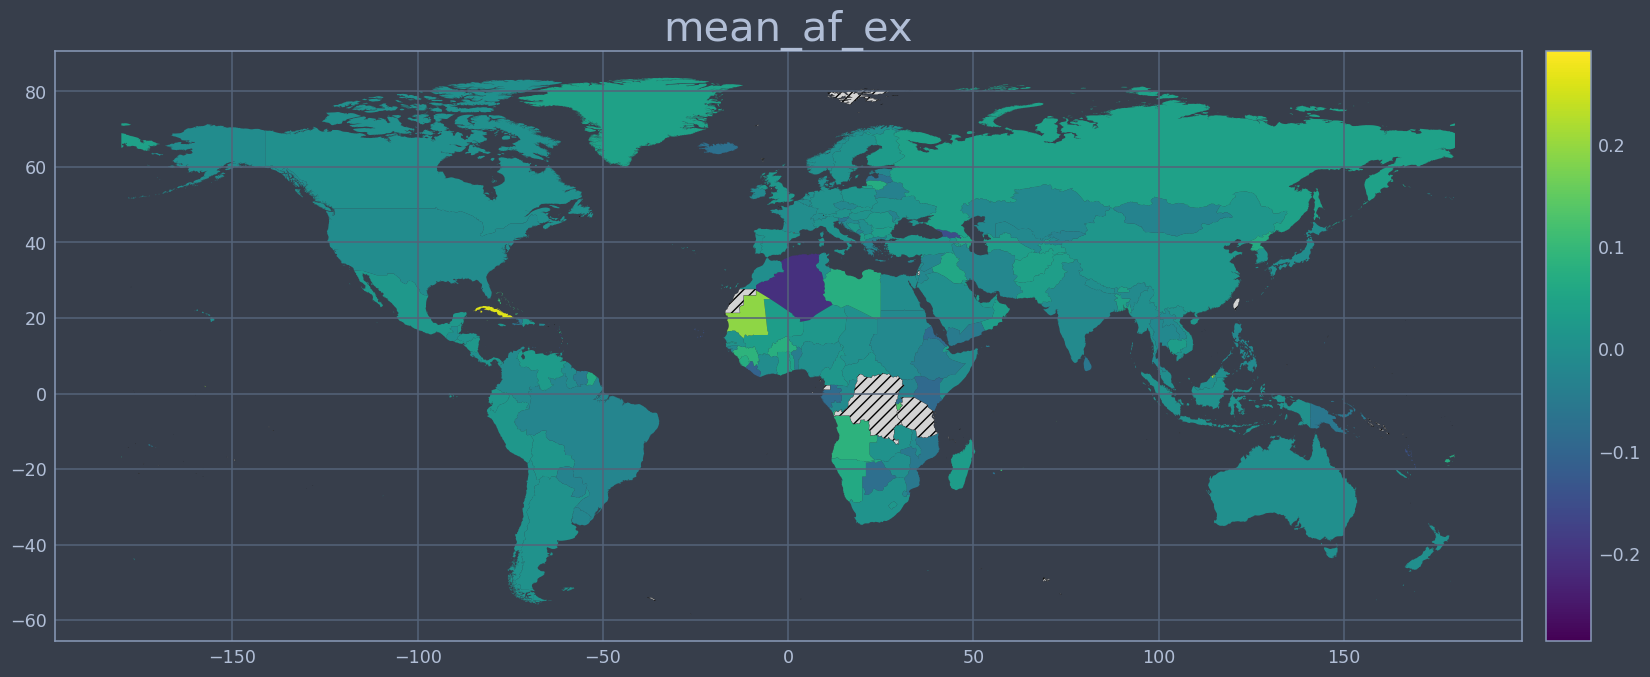

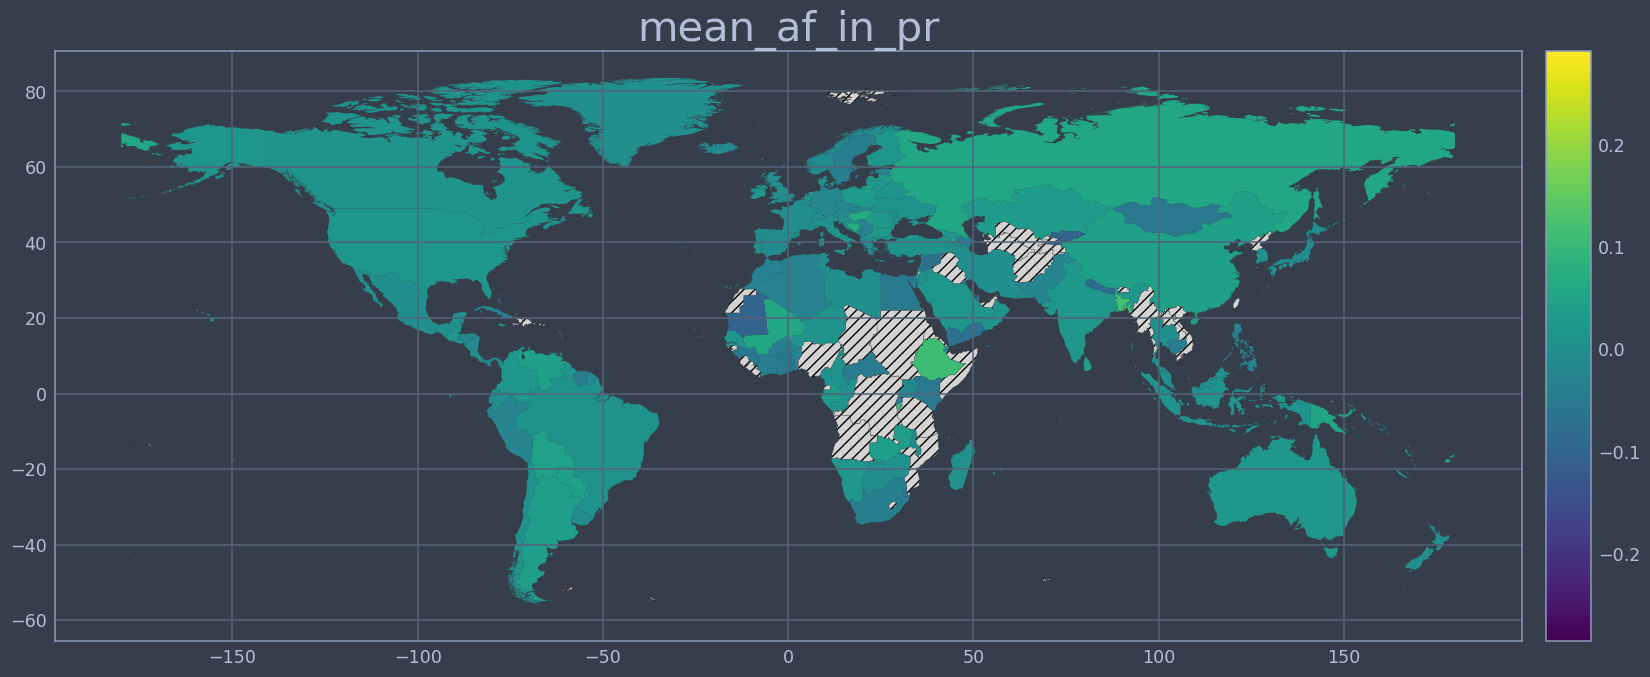

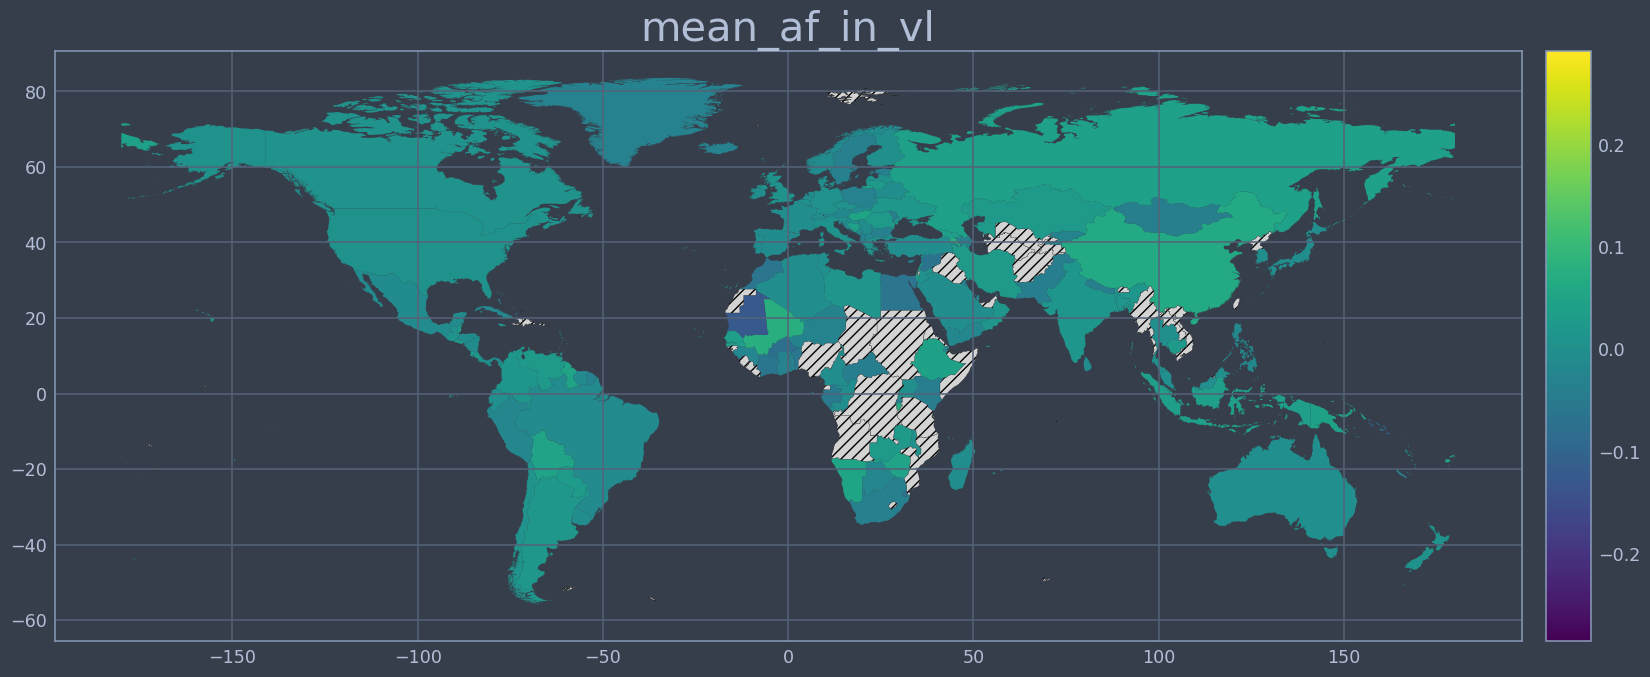

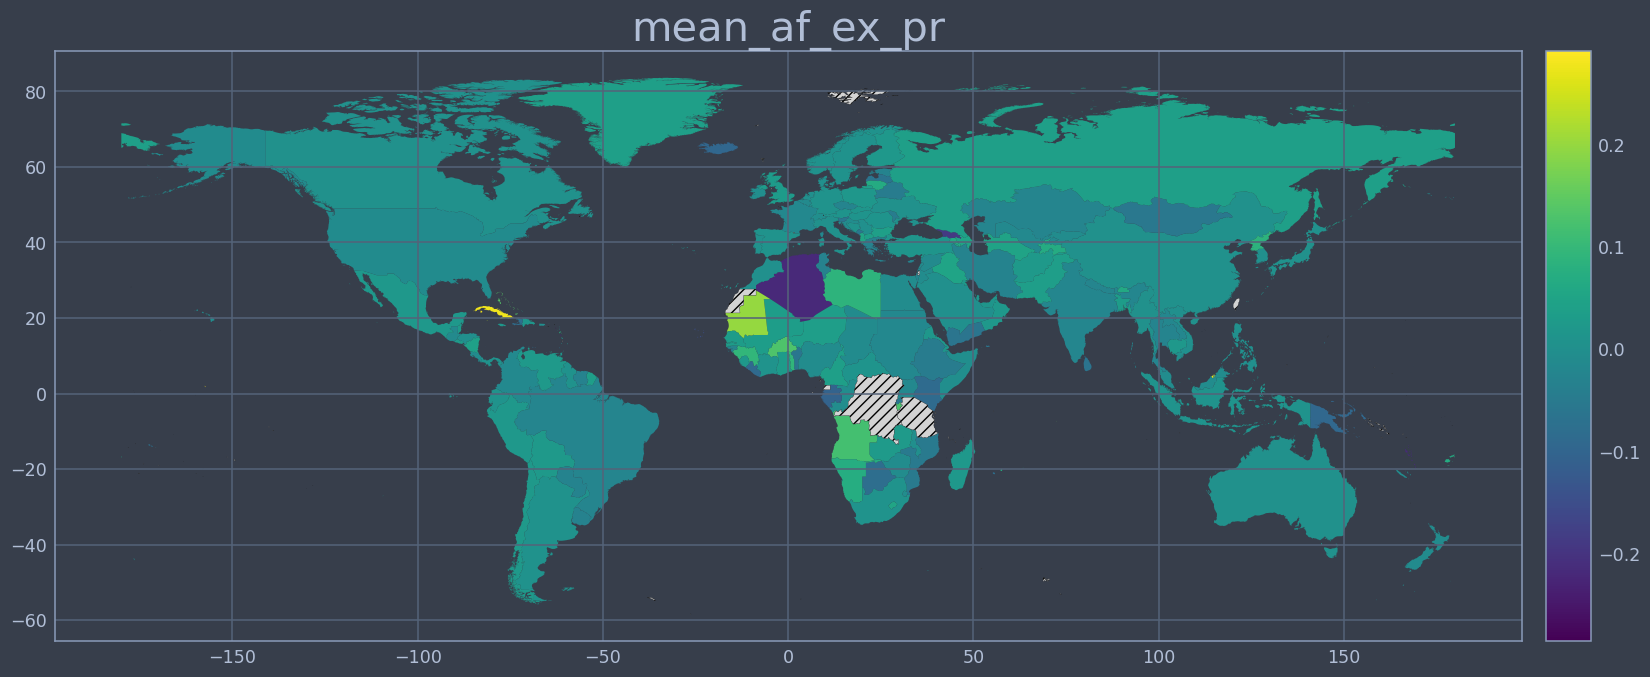

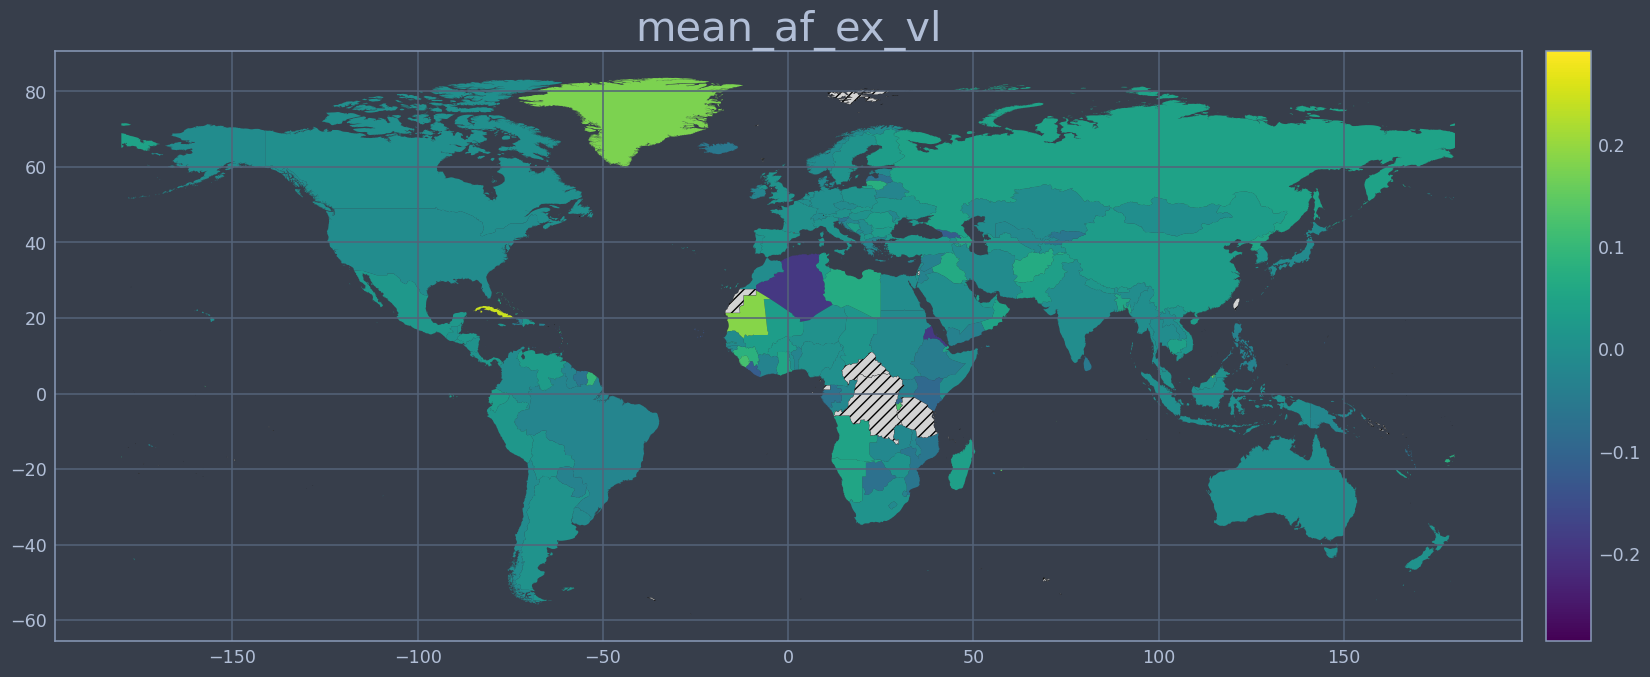

In [125]:
maps_plots() 

### Population-normalized antifragility {-}

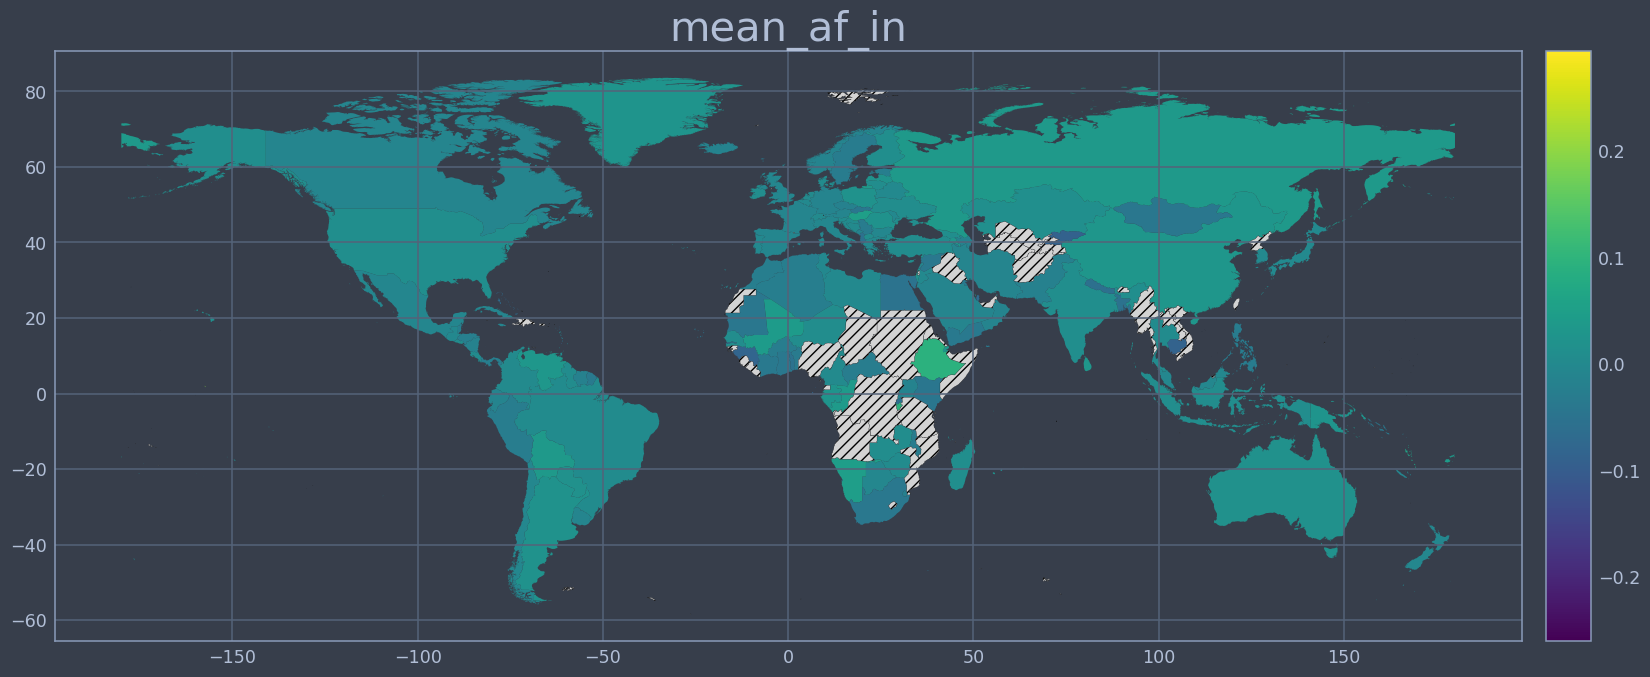

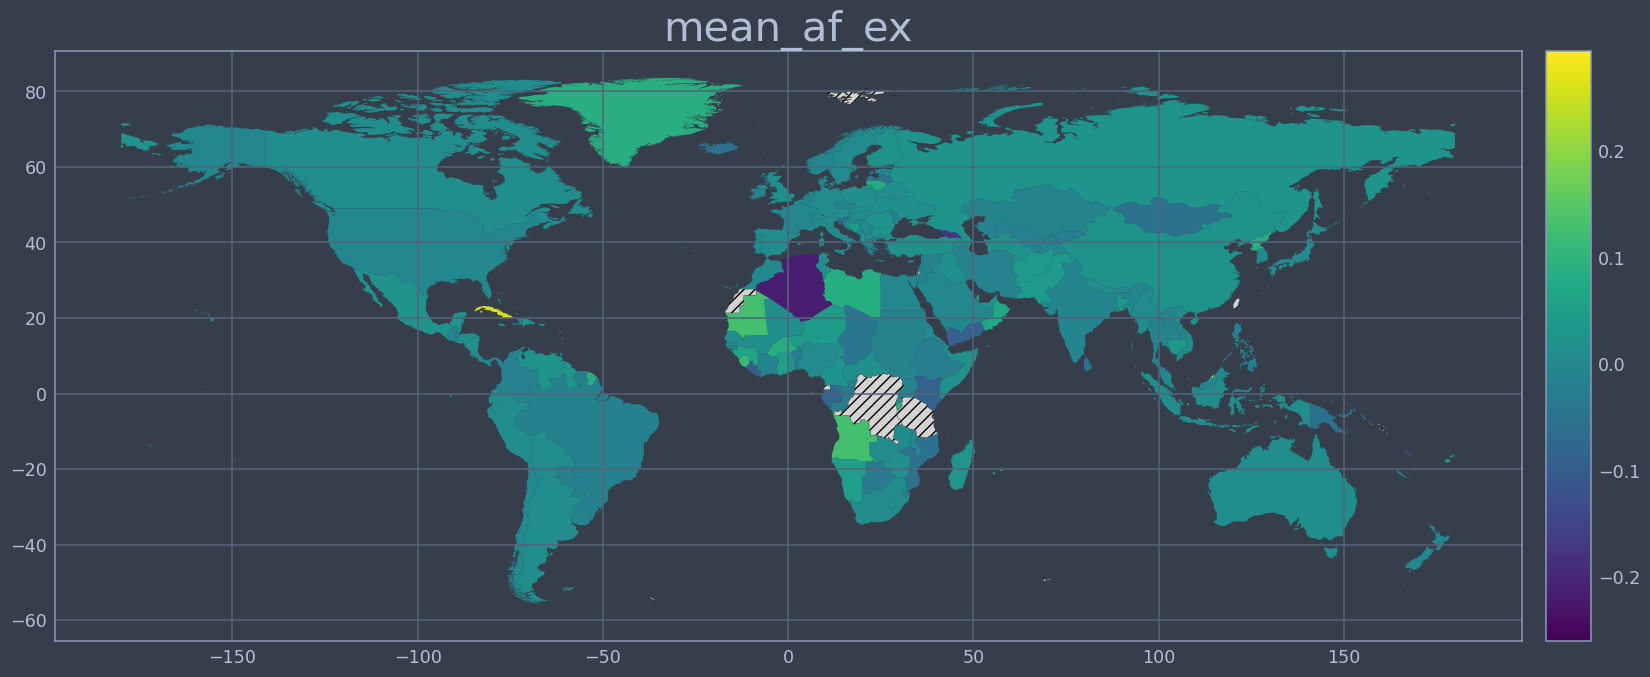

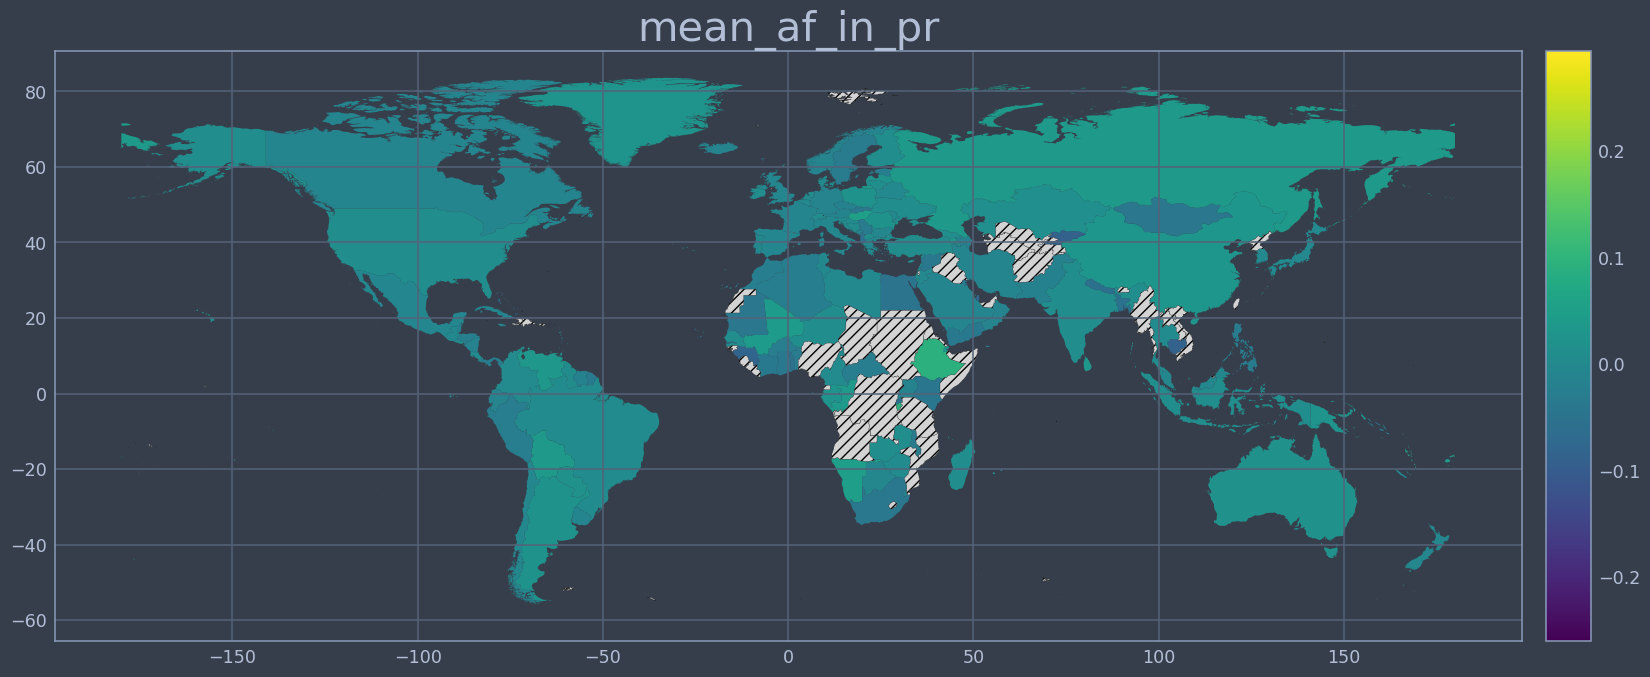

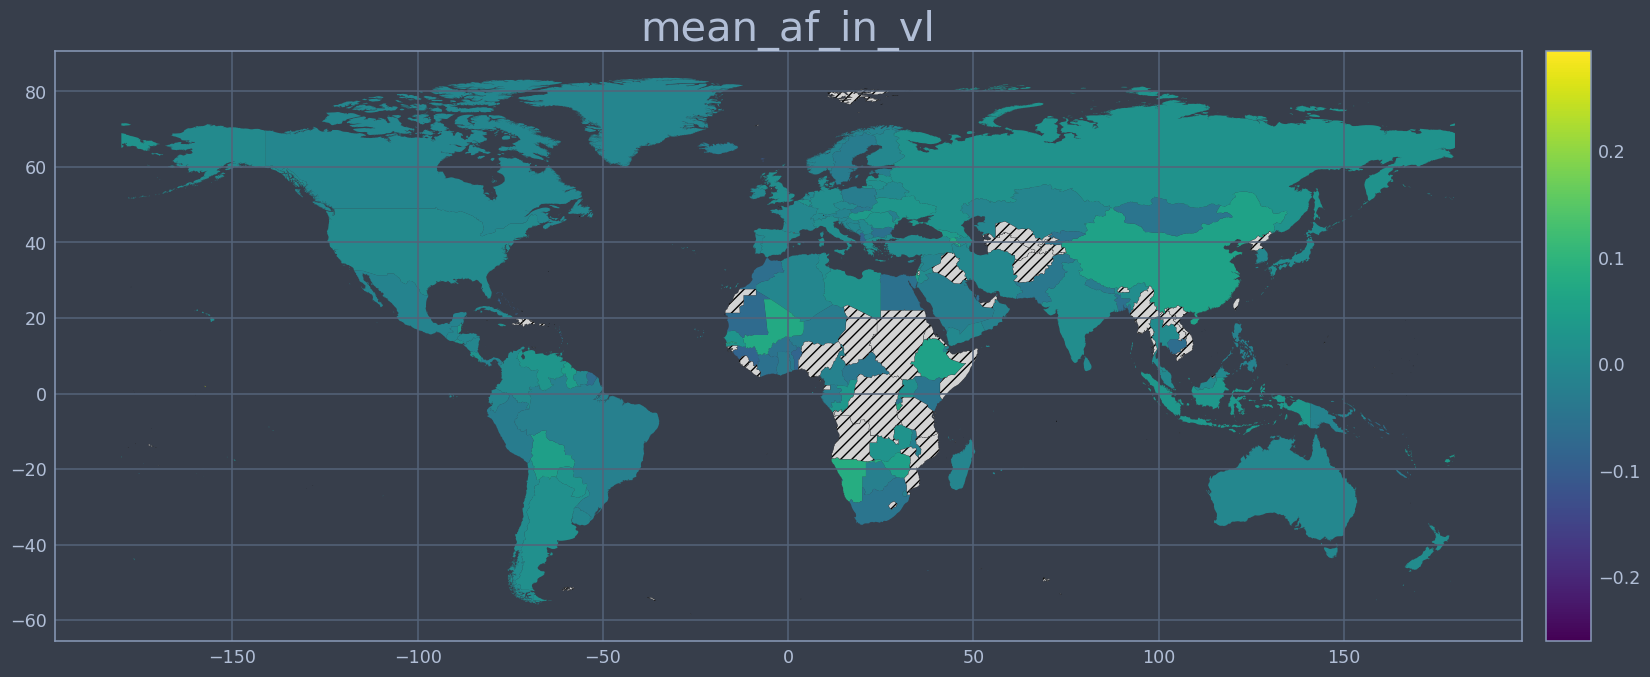

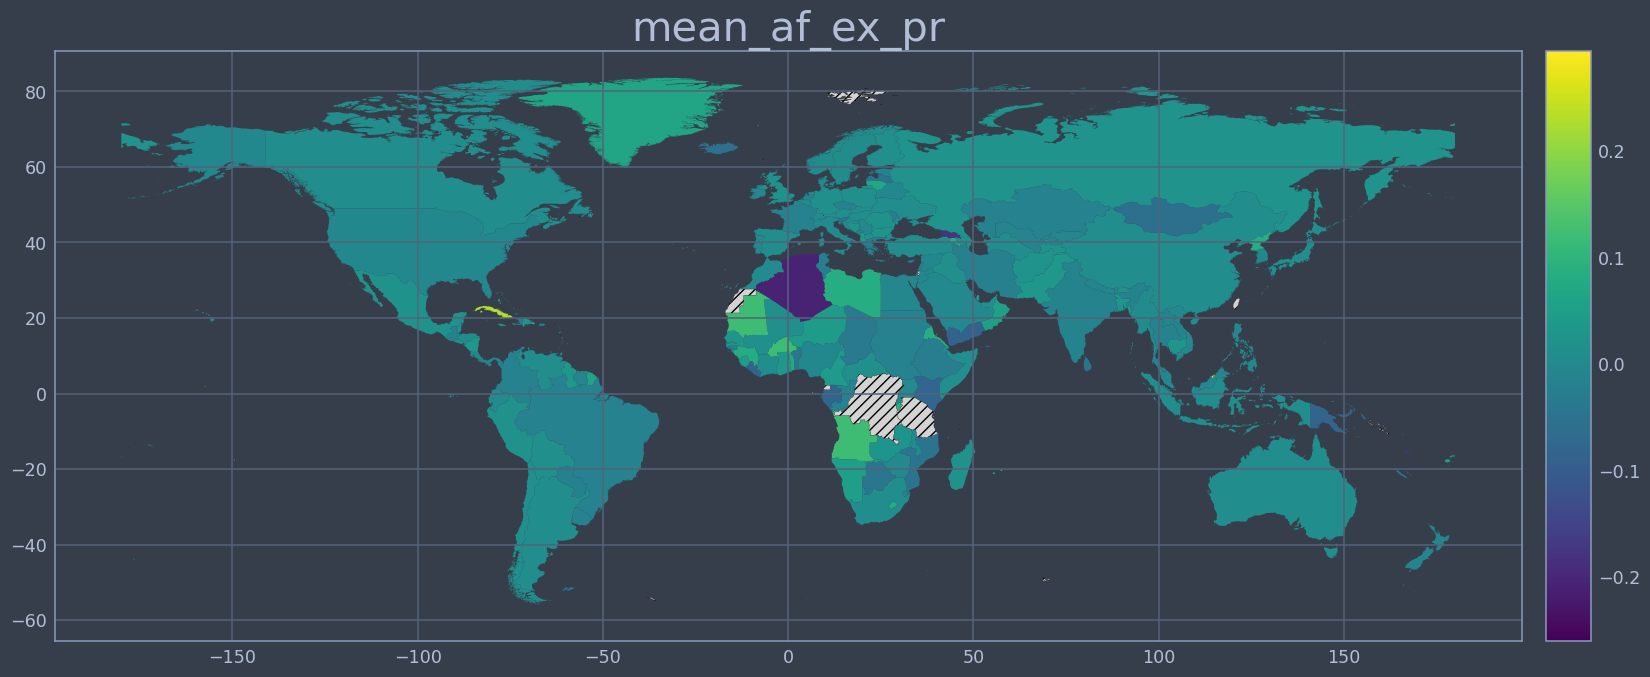

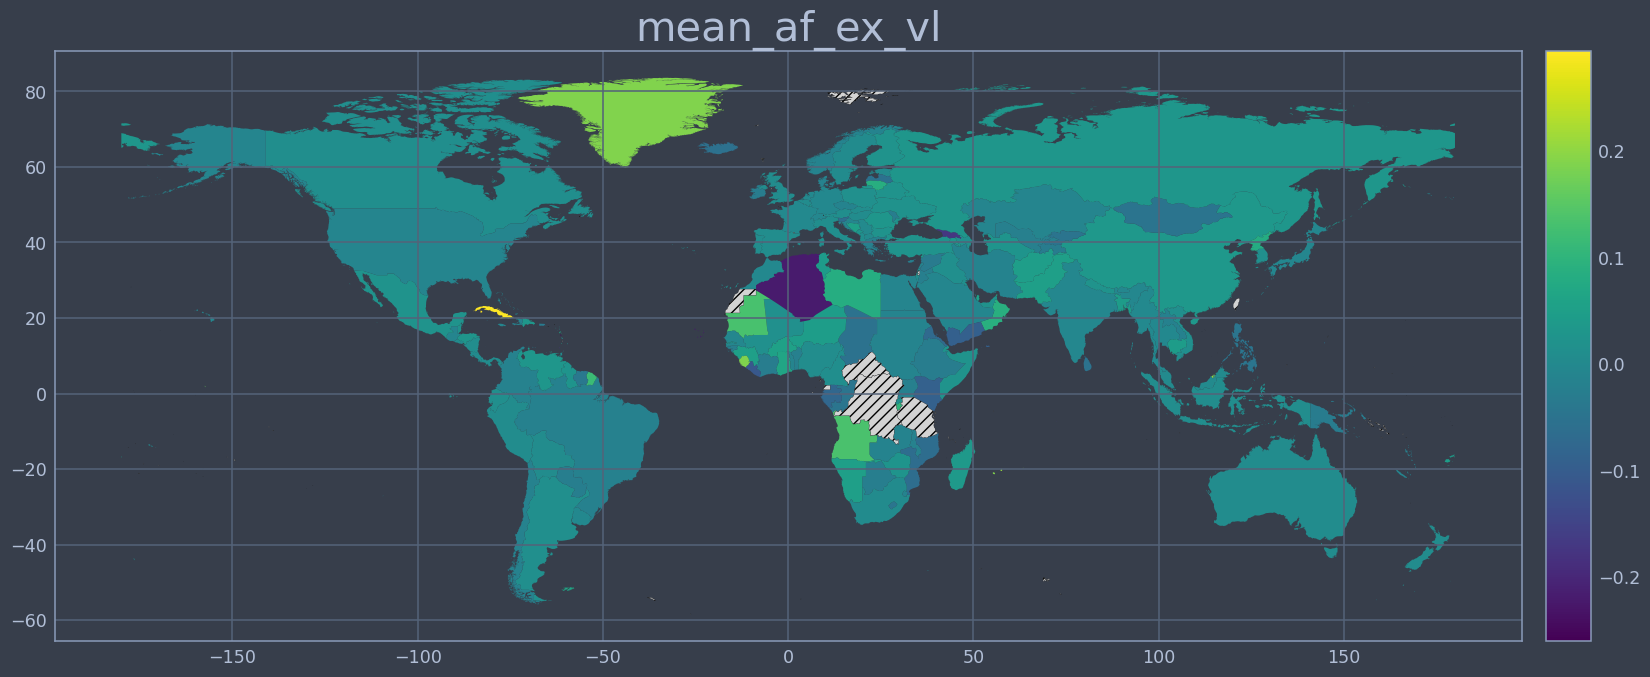

In [131]:
maps_plots() 

### GDP-normalized antifragility {-}

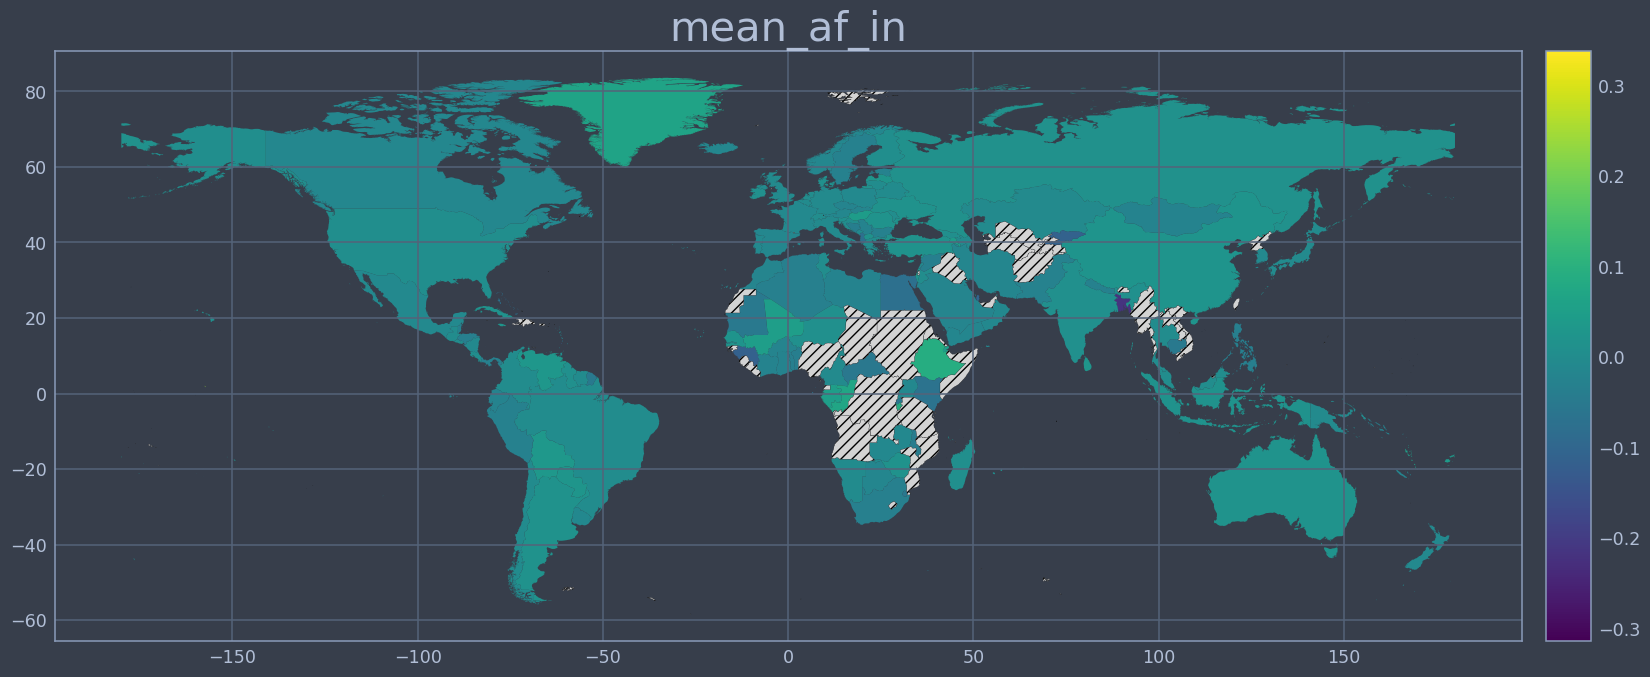

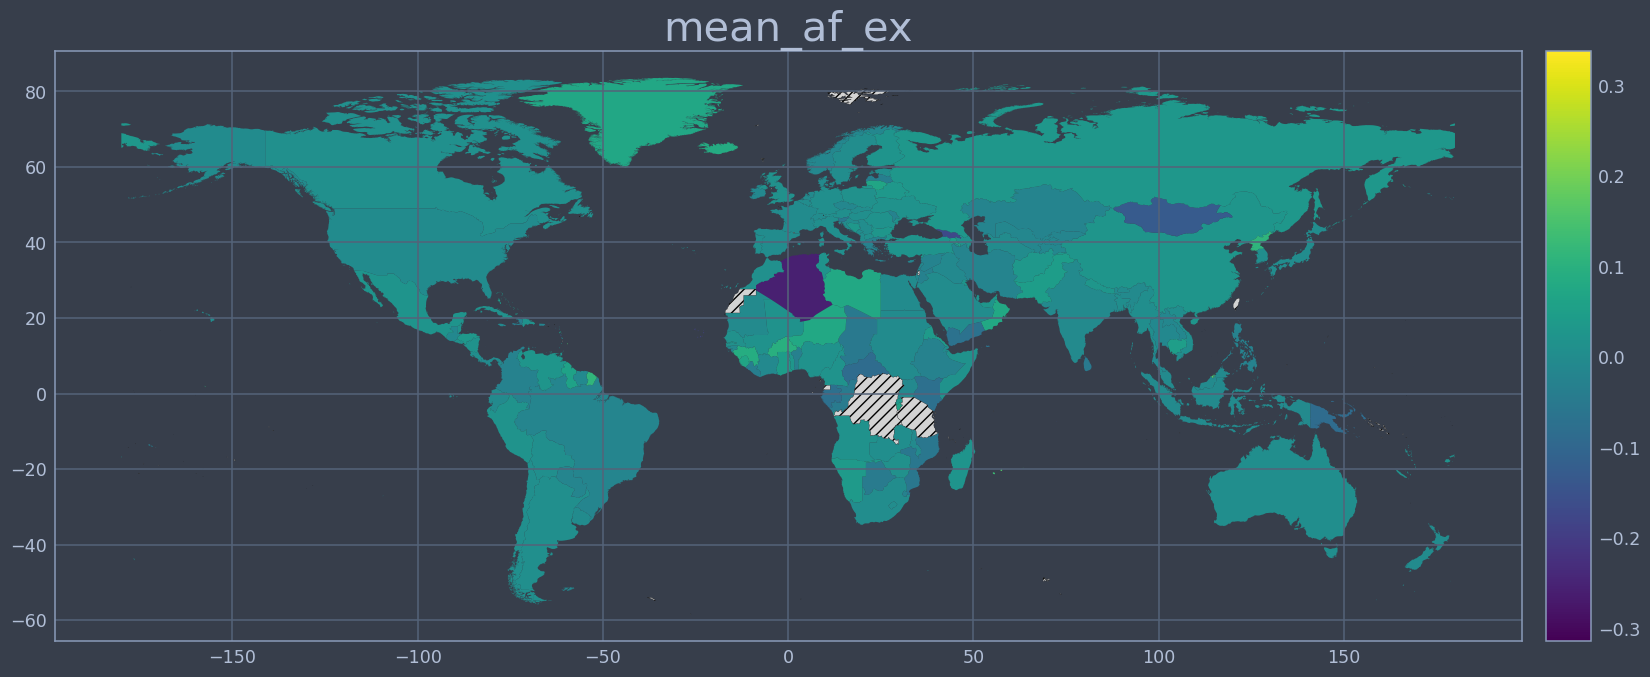

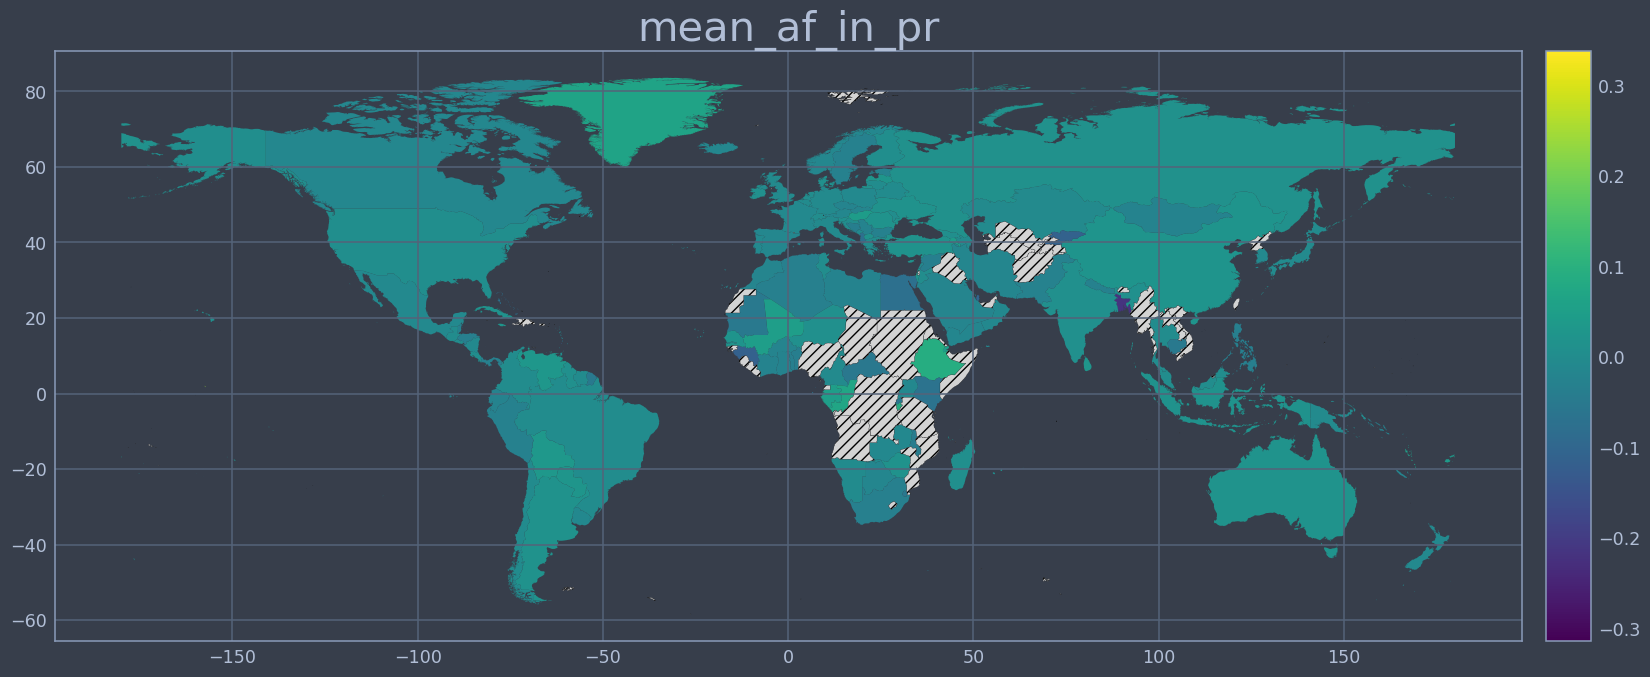

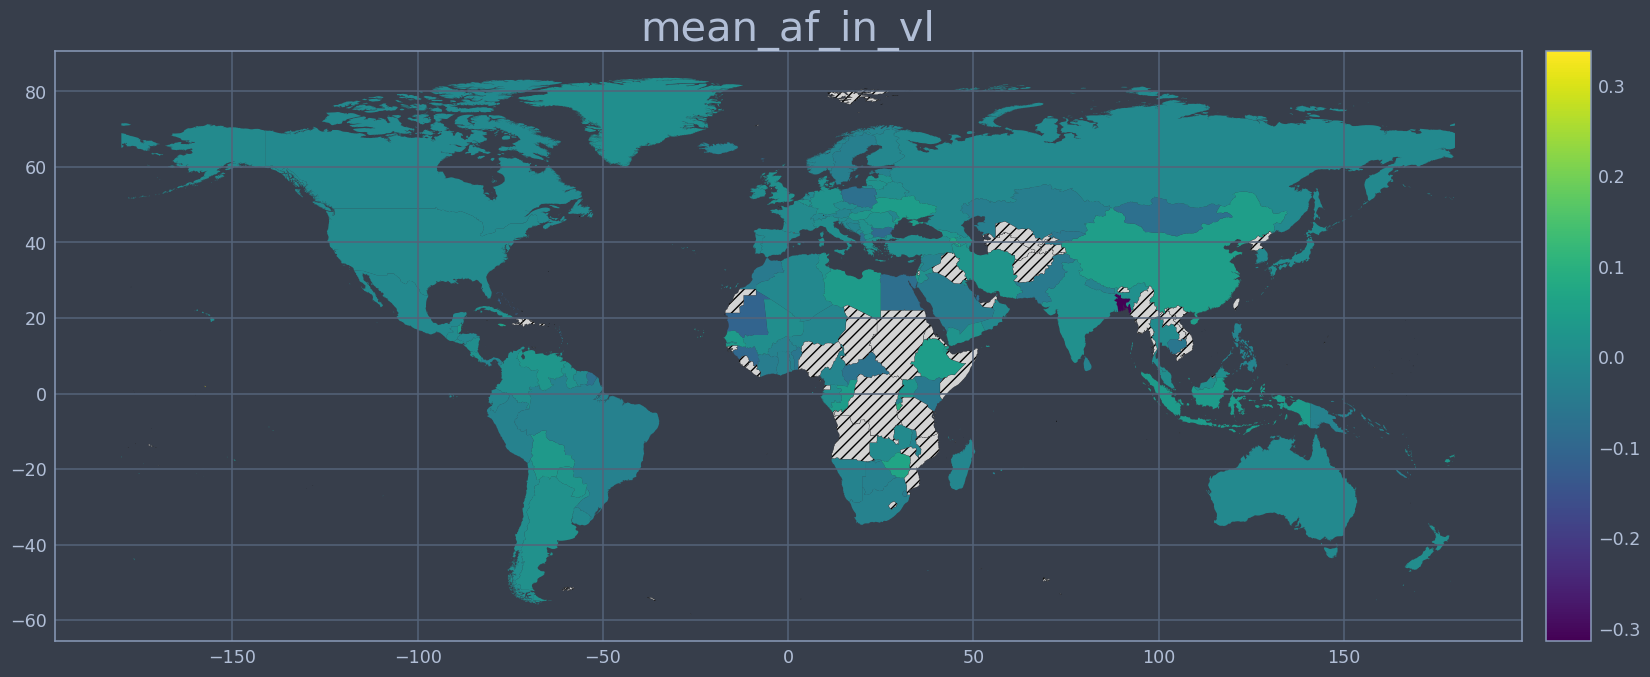

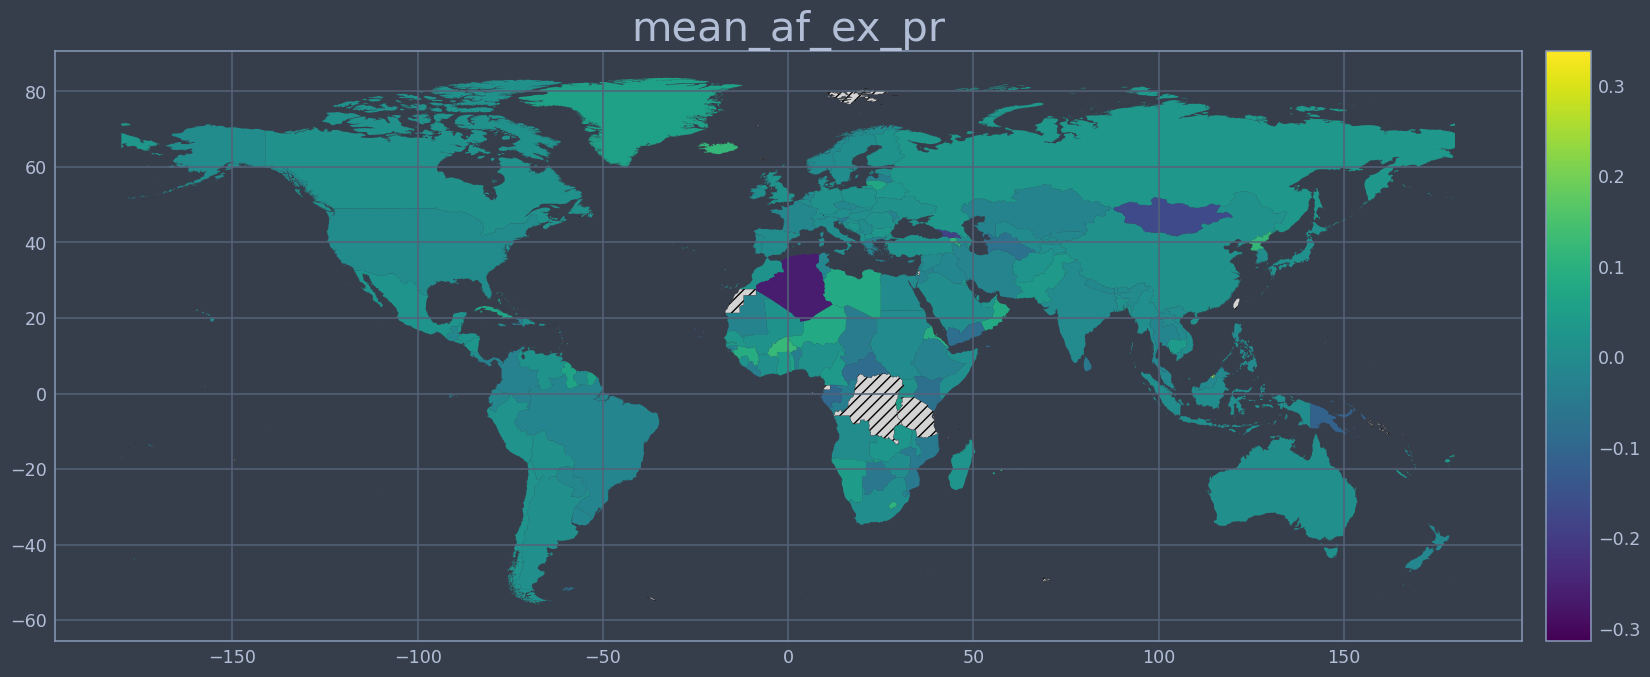

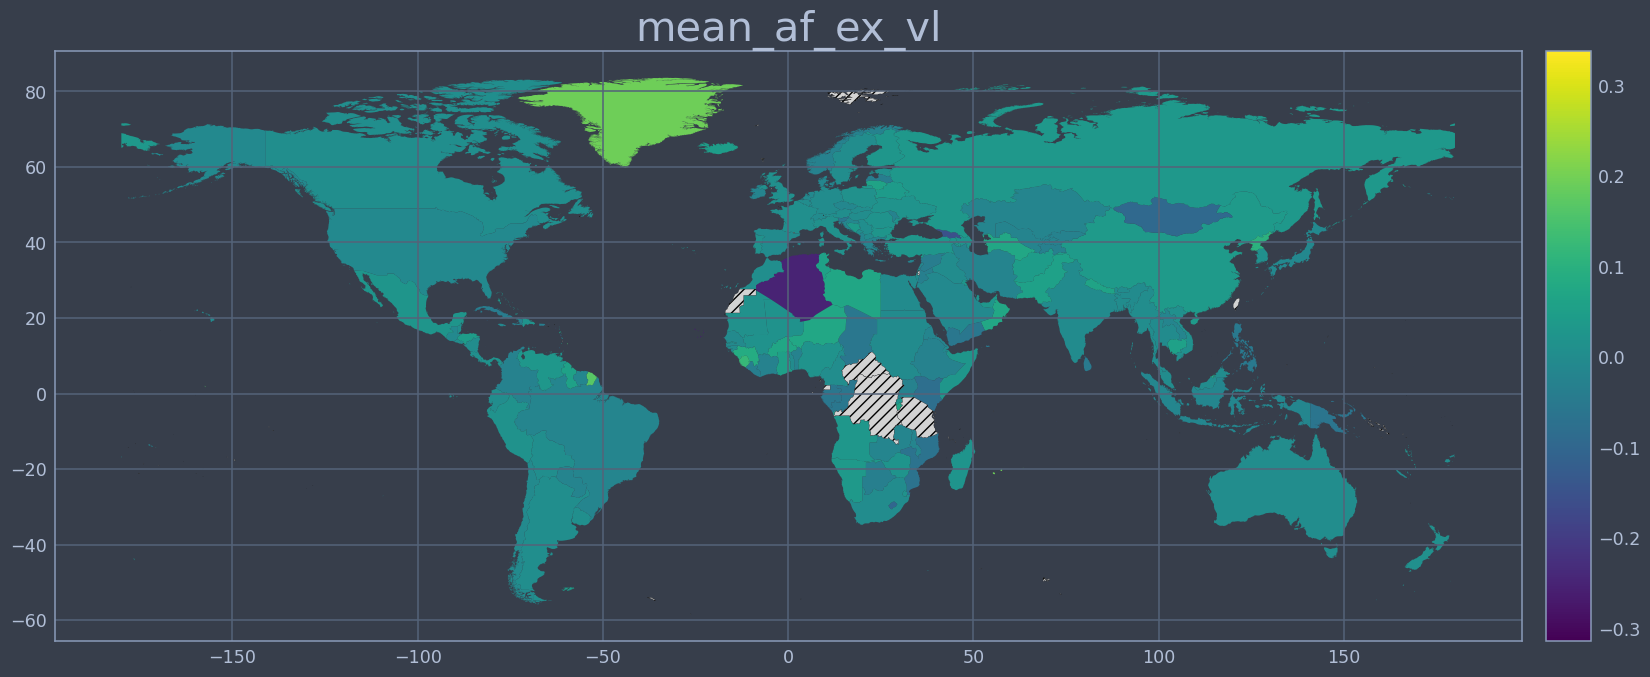

In [136]:
maps_plots()

In [104]:
total_mean=get_mean_af(a)

total_mean=total_mean.mean(axis=1)
total_mean.name='total_af'

world_total=pd.merge_ordered(world,total_mean,left_on='CNTRY_NAME',right_on=means_af_c.index,how='outer')